In [28]:
import os
import json
import glob
import pickle
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pathlib import Path
from sklearn.metrics import precision_recall_curve, roc_auc_score
from scipy.stats import pearsonr
from calibrator import IsotonicCalibrator, compute_calibration_error
from fairlearn.metrics import equalized_odds_difference, demographic_parity_difference

import warnings
warnings.filterwarnings('ignore')

# CONSTANTS
model = "LogisticRegression"
metric = "ACC_TEST"
n = 1000

base_log_dir = Path(f"../../yaib_logs/eicu/Mortality24/{model}/")

map_race = {0: 'asian', 
            1: 'black',
            2: 'other',
            3: 'white'}

map_gender = {0: 'Female', 1: 'Male'}

map_attribute = {'race0': 'asian',
                 'race1': 'black',
                 'race2': 'other',
                 'race3': 'white',
                 'gender0': 'Female',
                 'gender1': 'Male'}

reverse_map_attribute = {'asian': 'race0',
                         'black': 'race1',
                         'other': 'race2',
                         'white': 'race3',
                         'Female': 'gender0',
                         'Male': 'gender1'}

format_metric = {'ACC': 'Test Accuracy',
                 'ACC_TEST': 'Test Accuracy',
                 'AUC_TEST': 'Test AUC',
                 'AUC': 'Test AUC'}

hospital_ids = [73, 264, 420, 243, 338, 443, 199, 458, 300, 188, 252, 167]
hospital_dict = {} 
for i in range(len(hospital_ids)):
    hospital_dict[hospital_ids[i]] = i

In [29]:
# read hospital patient demographics
df_race = pd.read_csv('demo_data.csv')

# read patient data
df = pd.read_parquet('../../YAIB-cohorts/data/mortality24/eicu/sta.parquet', engine='pyarrow')

patient_hospital = pd.read_csv('../../YAIB-cohorts/data/mortality24/eicu/patient_hospital.csv')
patient_hospital = patient_hospital.rename(columns={'patientunitstayid': 'stay_id'})

df = df.merge(patient_hospital[['stay_id', 'hospitalid']], on='stay_id', how='left')
df = df.rename(columns={'hospitalid': 'hosp_id'})

# add outcome data
df_outc = pd.read_parquet('../../YAIB-cohorts/data/mortality24/eicu/outc.parquet', engine='pyarrow')

df = df.merge(df_outc, on='stay_id')

In [30]:
df[(df.label == 1) & (df.ethnic == 'asian') & (df.hosp_id.isin(hospital_ids))].hosp_id.value_counts()

hosp_id
420    6
167    4
458    3
73     2
188    2
252    2
300    2
199    1
264    1
338    1
443    1
Name: count, dtype: int64

In [31]:
# read base results
hospital_data = {}
for i in range(len(hospital_ids)):
    hospital_data[hospital_ids[i]] = {}

base_avg = np.load(f"../results/base/{model}-n{n}-avg.npz", allow_pickle=True)
metrics = list(base_avg.files)

for i, hos in enumerate(hospital_ids):
    hospital_data[hos]["AUC_TEST"] = base_avg["AUC_TEST"].item()[hos]
    hospital_data[hos]["ACC_TEST"] = base_avg["ACC_TEST"].item()[hos]
    
    for met in ["ACC_TEST", "AUC_TEST"]:
        min_auc = float('inf')
        min_metric = None
        
        for eth in range(1,4):
            auc_value = base_avg[f'race{eth}_{met}'].item()[hos]
            if auc_value < min_auc:
                min_auc = auc_value
                min_metric = map_race[eth]
            hospital_data[hospital_ids[i]][f'{map_attribute[f"race{eth}"]}_{met}'] = auc_value
        
        hospital_data[hospital_ids[i]][f"worst_{met}_subgroup"] = min_metric.split("_")[0]

# read results from data addition experiments

add_data_avg = np.load(f"../results/add_data/{model}-n{n}-avg.npz", allow_pickle=True)
add_data_std = np.load(f"../results/add_data/{model}-n{n}-std.npz", allow_pickle=True)
add_data_ci = np.load(f"../results/add_data/{model}-n{n}-ci.npz", allow_pickle=True)

auc_metrics = [metric for metric in add_data_avg.files if re.compile(r'.*AUC.*').match(metric)]
bacc_metrics = [metric for metric in add_data_avg.files if re.compile(r'.*BACC.*').match(metric)]
acc_metrics = [metric for metric in add_data_avg.files if re.compile(r'.*ACC.*').match(metric)]
acc_metrics = list(set(acc_metrics) - set(bacc_metrics))

base_columns = ['hosp_id', 'count', 'AUC', 'ACC']

addition_data = {} # {metric: results_arr}

# overall metric
addition_data[metric] = add_data_avg[metric]
addition_data[f"{metric}_diff"] = add_data_avg[metric] - [hospital_data[hos][metric] for hos in hospital_ids]
addition_data[f"{metric}_ci"] = (add_data_ci[metric][1] - add_data_ci[metric][0]) / 2

base_data = {}
# subgroup metrics
for i, subgroup in map_race.items():
    if i == 0:
        continue # skip asian
    
    add_data = add_data_avg[f"race{i}_{metric}"] # 12 x 12 arr
    add_ci = add_data_ci[f"race{i}_{metric}"] # 2 x 12 x 12 arr
    base_data[subgroup] = [hospital_data[hos][f"{subgroup}_{metric}"] for hos in hospital_ids] # 12 x 1 arr
    
    addition_data[f"race{i}_{metric}"] = add_data
    addition_data[f"race{i}_{metric}_diff"] = add_data - base_data[subgroup]  
    addition_data[f"race{i}_{metric}_ci"] = (add_ci[1] - add_ci[0]) / 2

# Section 1: Additional Fairness Metrics

Look at the effect of data addition on 

- Group Calibration Error
- Equalized Odds
- Demographic Parity

#### 1.1 Group Calibration Error

In [32]:
# for each add_data experiment
calibration_error = {subgroup: [] for subgroup in map_race.values() if subgroup != 'asian'}

for i, test_hos in enumerate(hospital_ids):
    for j, train_hos in enumerate(hospital_ids):
        if test_hos == train_hos:
            dir_str = f"train-test{test_hos}-n{n*2}"
        else:
            dir_str = f"train{train_hos}-{test_hos}-test{test_hos}-n{n}"
        exp_dir = os.path.join(base_log_dir, dir_str)
        files = os.listdir(exp_dir)
        files.sort()
        datetime = files[-1]

        # Initialize lists to store results across folds and repetitions
        base_changes = {subgroup: [] for subgroup in map_race.values() if subgroup != 'asian'}

        # Iterate through all repetitions and folds
        for rep in range(5):  # 5 repetitions
            for fold in range(5):  # 5 folds
                try:
                    patient_results = np.load(os.path.join(exp_dir, datetime, f'repetition_{rep}/fold_{fold}/patient_results.npz'))
                except:
                    print(f"no patient results for {dir_str}")

                test_ids = patient_results['test_ids']
                test_races = pd.DataFrame({'stay_id': test_ids}).merge(df, on='stay_id')['ethnic'].values
                
                test_labels = patient_results['true_labels']
                test_probs = patient_results['predictions']
                test_preds = patient_results['pred_labels']

                test_hosps = pd.DataFrame({'stay_id':test_ids}).merge(df, on='stay_id')['hosp_id'].values
                
                assert np.all(test_hosps == test_hos)
                
                # group by subgroup
                for i, subgroup in map_race.items():
                    if i != 0:
                        test_subg_idx = np.where(test_races == subgroup)[0]
                            
                        # Compute ECE
                        base_ece = compute_calibration_error(test_labels[test_subg_idx], test_probs[test_subg_idx], n_bins=50)
                        subg_base_acc = np.mean(test_preds[test_subg_idx] == test_labels[test_subg_idx])
                        
                        # Store ECE changes
                        base_changes[subgroup].append((subg_base_acc, base_ece))

        # Average results across all folds and repetitions
        for subgroup in calibration_error.keys():
            calibration_error[subgroup].append((np.mean([item[0] for item in base_changes[subgroup]]), np.mean([item[1] for item in base_changes[subgroup]])))

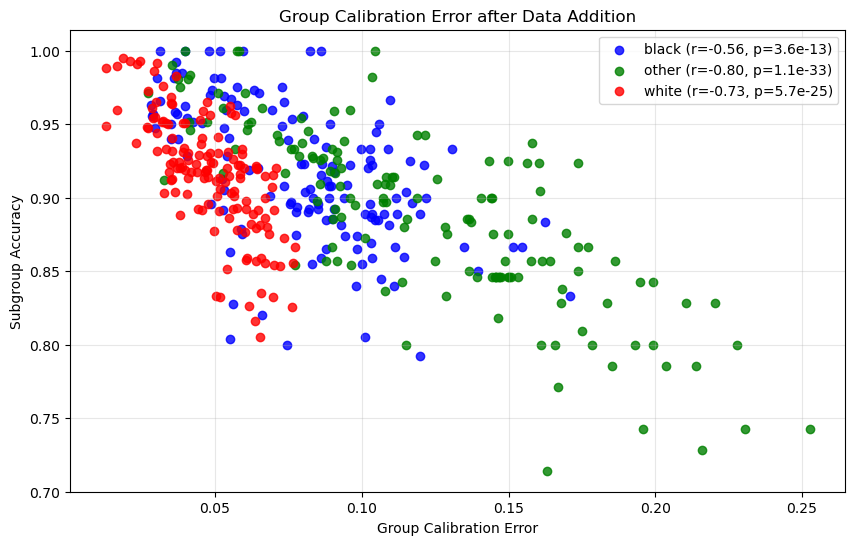

In [33]:
# VISUALIZATION: Calibration Error pre-calibration post-addition
# scatter plot of CHANGES colored by subgroup

# Scatter plot with different colors for each subgroup
plt.figure(figsize=(10, 6))

colors = {'black': 'blue', 'other': 'green', 'white': 'red'}
for subgroup, data in calibration_error.items():
    data = [(a, b) for a, b in data if not (np.isnan(a) or np.isnan(b))]

    if len(data) > 0:
        x_group = [point[0] for point in data]
        y_group = [point[1] for point in data]
        
        # Compute correlation coefficient and p-value for this subgroup
        corr_coef, p_val = pearsonr(x_group, y_group)
        label=f"{subgroup} (r={corr_coef:.2f}, p={p_val:.2g})"
        
        # Add scatter points for the subgroup
        plt.scatter(y_group, x_group, 
                   label=label, 
                   color=colors[subgroup], 
                   alpha=0.8)

plt.title('Group Calibration Error after Data Addition')
plt.xlabel('Group Calibration Error')
plt.ylabel('Subgroup Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

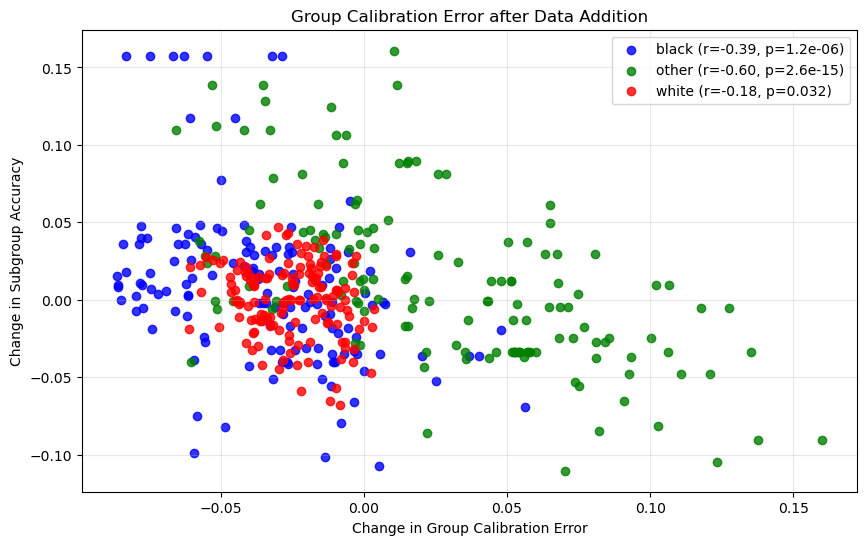

In [34]:
# get pre-addition calibration error
pre_addition_calibration_error = {subgroup: [] for subgroup in map_race.values() if subgroup != 'asian'}

for i, hos in enumerate(hospital_ids):
    dir_str = f"train-test{test_hos}-n{n}"

    ece_vals = {subgroup: [] for subgroup in map_race.values() if subgroup != 'asian'}

    # Iterate through all repetitions and folds
    for rep in range(5):  # 5 repetitions
        for fold in range(5):  # 5 folds
            try:
                patient_results = np.load(os.path.join(exp_dir, datetime, f'repetition_{rep}/fold_{fold}/patient_results.npz'))
            except:
                print(f"no patient results for {dir_str}")

            test_ids = patient_results['test_ids']
            test_races = pd.DataFrame({'stay_id': test_ids}).merge(df, on='stay_id')['ethnic'].values
            
            test_labels = patient_results['true_labels']
            test_probs = patient_results['predictions']
            test_preds = patient_results['pred_labels']

            for j, subgroup in map_race.items(): 
                if j != 0:
                    test_subg_idx = np.where(test_races == subgroup)[0]          
                    
                    ece = compute_calibration_error(test_labels[test_subg_idx], test_probs[test_subg_idx], n_bins=50)
                    ece_vals[subgroup].append(ece)
    
    for subgroup in ece_vals.keys():
        pre_addition_calibration_error[subgroup].append(np.mean(ece_vals[subgroup]))

# VISUALIZATION: Calibration Error pre-calibration post-addition
# scatter plot of CHANGES colored by subgroup

# Scatter plot with different colors for each subgroup
plt.figure(figsize=(10, 6))

colors = {'black': 'blue', 'other': 'green', 'white': 'red'}

for subgroup, data in calibration_error.items():
    if len(data) > 0:
        x_group = [point[0] - base_data[subgroup][i//12] for i, point in enumerate(data)]
        y_group = [point[1] - pre_addition_calibration_error[subgroup][i//12] for i, point in enumerate(data)]
        
        data = [(x, y) for x, y in zip(x_group, y_group) if not (np.isnan(x) or np.isnan(y))]

        # Compute correlation coefficient and p-value for this subgroup
        corr_coef, p_val = pearsonr([pair[0] for pair in data], [pair[1] for pair in data])
        
        # Add scatter points for the subgroup
        plt.scatter(y_group, x_group, 
                   label=f"{subgroup} (r={corr_coef:.2f}, p={p_val:.2g})", 
                   color=colors[subgroup], 
                   alpha=0.8)

plt.title('Group Calibration Error after Data Addition')
plt.xlabel('Change in Group Calibration Error')
plt.ylabel('Change in Subgroup Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

#### 1.2 Equalized Odds and Demographic Parity

In [35]:
# get base Equalized Odds without data addition
base_eos = {}
base_dps = {}

for i, hos in enumerate(hospital_ids):
    # Need: pred_labels, true_labels, subgroups
    dir_str = f"train-test{hos}-n{n}"

    exp_dir = os.path.join(base_log_dir, dir_str)
    files = os.listdir(exp_dir)
    files.sort()
    datetime = files[-1]

    eos = []
    dps = []

    for rep in range(5):
        for fold in range(5):
            try:
                patient_results = np.load(os.path.join(exp_dir, datetime, f'repetition_{rep}/fold_{fold}/patient_results.npz'))
            except:
                print(f"no patient results for {dir_str}")

            pred_labels = patient_results['pred_labels']
            true_labels = patient_results['true_labels']

            test_ids = patient_results['patient_ids']
            races = pd.DataFrame({'stay_id': test_ids}).merge(df, on='stay_id')['ethnic'].values

            mask = pd.notna(races) & (races != "asian")
            pred_labels = pred_labels[mask]
            true_labels = true_labels[mask]
            races = races[mask]

            eos.append(equalized_odds_difference(true_labels, pred_labels, sensitive_features=races))
            dps.append(demographic_parity_difference(true_labels, pred_labels, sensitive_features=races))

    base_eos[hos] = np.nanmean(eos)
    base_dps[hos] = np.nanmean(dps)

In [36]:
# get Equalized Odds with Whole-Hospital data addition

# get base Equalized Odds without data addition
add_eos_diffs = {hos: [] for hos in hospital_ids}
add_dps_diffs = {hos: [] for hos in hospital_ids}

for i, test_hos in enumerate(hospital_ids):
    for j, train_hos in enumerate(hospital_ids):
        # Need: pred_labels, true_labels, subgroups
        if test_hos == train_hos:
            dir_str = f"train-test{test_hos}-n{n*2}"
        else:
            dir_str = f"train{train_hos}-{test_hos}-test{test_hos}-n{n}"

        exp_dir = os.path.join(base_log_dir, dir_str)
        files = os.listdir(exp_dir)
        files.sort()
        datetime = files[-1]

        eos = []
        dps = []

        for rep in range(5):
            for fold in range(5):
                try:
                    patient_results = np.load(os.path.join(exp_dir, datetime, f'repetition_{rep}/fold_{fold}/patient_results.npz'))
                except:
                    print(f"no patient results for {dir_str}")

                pred_labels = patient_results['pred_labels']
                true_labels = patient_results['true_labels']

                test_ids = patient_results['test_ids']
                races = pd.DataFrame({'stay_id': test_ids}).merge(df, on='stay_id')['ethnic'].values

                mask = pd.notna(races) & (races != "asian")
                pred_labels = pred_labels[mask]
                true_labels = true_labels[mask]
                races = races[mask]

                eos.append(equalized_odds_difference(true_labels, pred_labels, sensitive_features=races))
                dps.append(demographic_parity_difference(true_labels, pred_labels, sensitive_features=races))

        add_eos_diffs[test_hos].append(np.nanmean(eos) - base_eos[test_hos])
        add_dps_diffs[test_hos].append(np.nanmean(dps) - base_dps[test_hos])

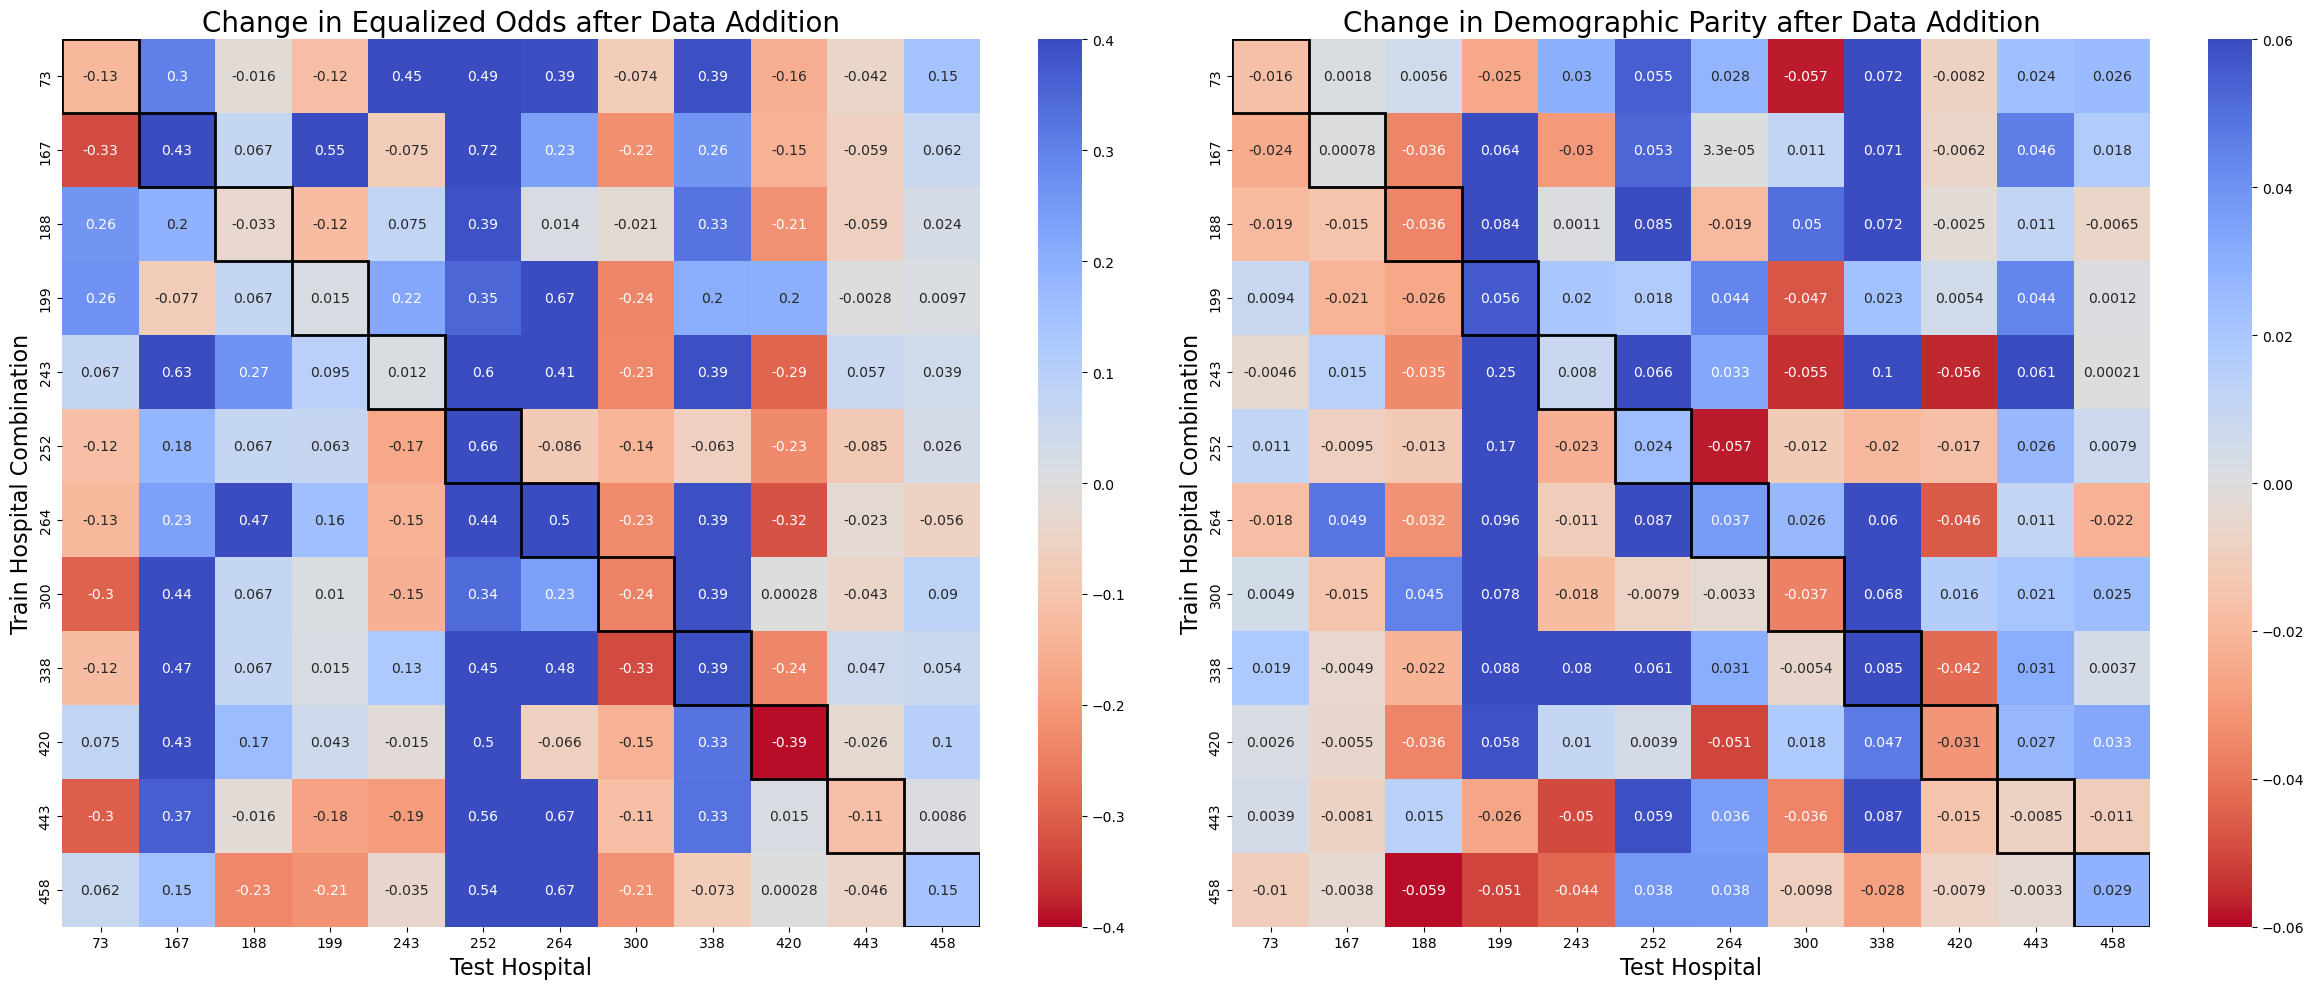

In [53]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Define the two different configurations
configs = [
    {'data': add_eos_diffs, 'metric': 'Equalized Odds', 'ax': ax1, 'limit': 0.4},
    {'data': add_dps_diffs, 'metric': 'Demographic Parity', 'ax': ax2, 'limit': 0.06}
]

for config in configs:
    data = config['data']
    metric = config['metric']
    ax = config['ax']
    
    plot_data = np.array([data[hos] for hos in sorted(data.keys())]).T
    
    # Get hospital IDs from the dict keys
    hospital_ids = sorted(data.keys())
    
    # Create diverging colormap centered at 0
    min_val = np.nanmin(plot_data)
    max_val = np.nanmax(plot_data)
    # limit = max(abs(min_val), abs(max_val)) / 2
    limit = config['limit']  # Or use a fixed limit
    
    # Create heatmap
    sns.heatmap(plot_data, annot=True, cmap='coolwarm_r', 
                xticklabels=hospital_ids, yticklabels=hospital_ids, 
                vmin=-limit, vmax=limit, center=0, ax=ax)
    
    # Outline the diagonal cells
    num_rows, num_cols = plot_data.shape
    for i in range(min(num_rows, num_cols)):
        rect = Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=2)
        ax.add_patch(rect)
    
    ax.set_title(f"Change in {metric} after Data Addition", fontsize=20)
    ax.set_xlabel("Test Hospital", fontsize=16)
    ax.set_ylabel("Train Hospital Combination", fontsize=16)

plt.tight_layout()
plt.show()

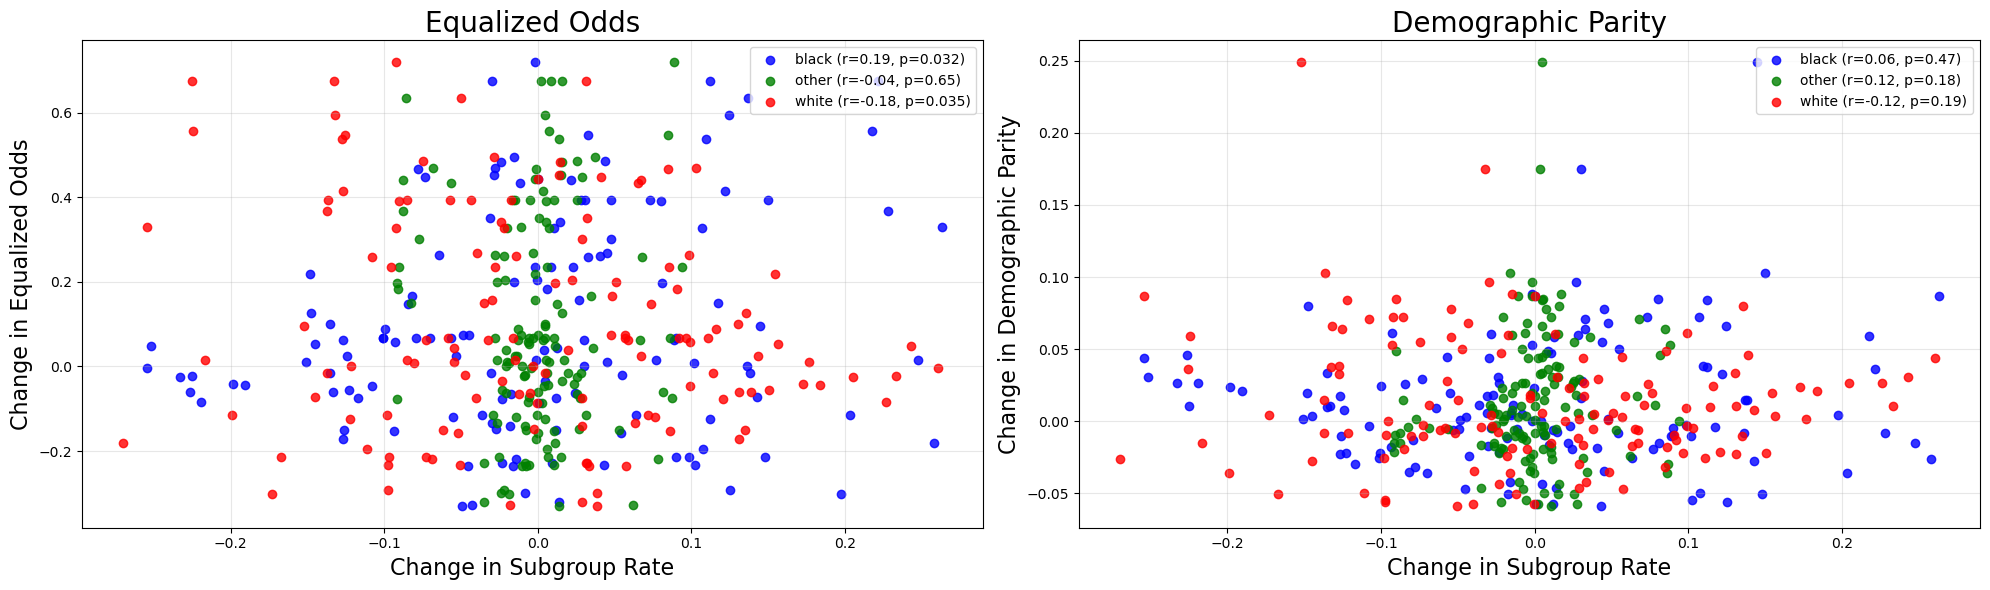

In [54]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Define the two different configurations
configs = [
    {'metric_diffs': add_eos_diffs, 'metric': 'Equalized Odds', 'ax': ax1},
    {'metric_diffs': add_dps_diffs, 'metric': 'Demographic Parity', 'ax': ax2}
]

colors = {'black': 'blue', 'other': 'green', 'white': 'red'}

for config in configs:
    metric_diffs = config['metric_diffs']
    metric = config['metric']
    ax = config['ax']
    
    # visualization: Data Balancing via Addition vs. Change in metric
    datapoints = {subgroup: [] for subgroup in ['black', 'other', 'white']}

    for j, test_hos in enumerate(hospital_ids):
        for k, train_hos in enumerate(hospital_ids):
            if j != k:
                dir_str = f"train{train_hos}-{test_hos}-test{test_hos}-n{n}"
                exp_dir = os.path.join(base_log_dir, dir_str)
                files = os.listdir(exp_dir)
                files.sort()
                datetime = files[-1]
                
                patient_results = np.load(os.path.join(exp_dir, datetime, 'repetition_0/fold_0/patient_results.npz'))
                
                train_ids = patient_results['train_ids']
                train_races = patient_results['train_races']

                train_hosps = pd.DataFrame({'stay_id': train_ids}).merge(df, on='stay_id')['hosp_id'].values
                
                samples_added = np.sum(train_hosps == train_hos)
                for i, subgroup in enumerate(['black', 'other', 'white'], start=1):
                    rate_new = (np.sum(train_races==i) / len(train_races)) 
                    rate_base = (np.sum((train_races==i) & (train_hosps==test_hos)) / np.sum(train_hosps==test_hos))
                    rate_change = rate_new - rate_base
                    
                    metric_change = metric_diffs[test_hos][k]
                    if not np.isnan(metric_change):
                        datapoints[subgroup].append((rate_change, metric_change))
                                
    # Scatter plot with different colors for each subgroup
    for subgroup, data in datapoints.items():
        x_group = [point[0] for point in data]
        y_group = [point[1] for point in data]
        
        # Compute correlation coefficient and p-value for this subgroup
        corr_coef, p_val = pearsonr(x_group, y_group)
        
        # Add scatter points for the subgroup
        ax.scatter(x_group, y_group, 
                    label=f"{subgroup} (r={corr_coef:.2f}, p={p_val:.2g})", 
                    color=colors[subgroup], 
                    alpha=0.8)

    ax.set_xlabel('Change in Subgroup Rate', fontsize=16)
    ax.set_ylabel(f'Change in {metric}', fontsize=16)
    ax.set_title(f"{metric}", fontsize=20)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# visualization: Distribution Matching via Addition vs. Change in EO


# Section 2: Additional Similarity Metrics

In this section, we look at KL-Divergence as a similarity score.

In [26]:
scores_x = np.load("../results/distances/score-x.npy")
scores_xy = np.load("../results/distances/score-xy.npy")

kl = np.load("../results/distances/KL-n2000.npz")["KL_xy"][0]

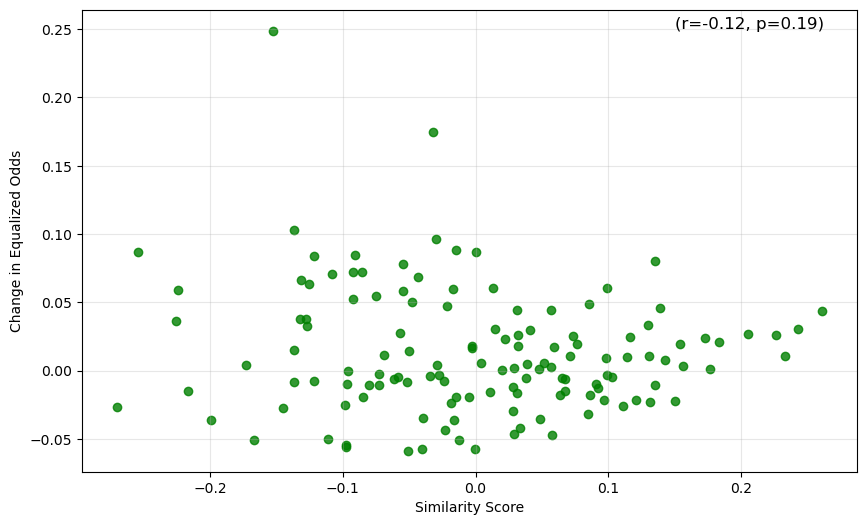

In [65]:
# VISUALIZATION: kl/score vs. change in EO/DP after addition (144 points, no subgroup differentiation)
score_mat = kl
metric_diffs = add_eos_diffs # CHANGE BETWEEN ADD_DPS_DIFFS AND ADD_EOS_DIFFS

# visualization: Data Balancing via Addition vs. Change in EO
datapoints = []

for j, test_hos in enumerate(hospital_ids):
    for k, train_hos in enumerate(hospital_ids):
        score = score_mat[j,k]
        metric_change = metric_diffs[test_hos][k]
        if not np.isnan(metric_change):
            datapoints.append((score, metric_change))
                            
# Scatter plot with different colors for each subgroup
plt.figure(figsize=(10, 6))

# if len(data) > 0:  # Only plot if we have data for this subgroup
x_group = [point[0] for point in data]
y_group = [point[1] for point in data]

# Compute correlation coefficient and p-value for this subgroup
corr_coef, p_val = pearsonr(x_group, y_group)

# Add scatter points for the subgroup
plt.scatter(x_group, y_group, 
            alpha=0.8, color='green')
plt.text(0.15, 0.25,f"(r={corr_coef:.2f}, p={p_val:.2g})", fontsize=12, color='black')

plt.xlabel('Similarity Score')
plt.ylabel('Change in Equalized Odds')
plt.grid(True, alpha=0.3)


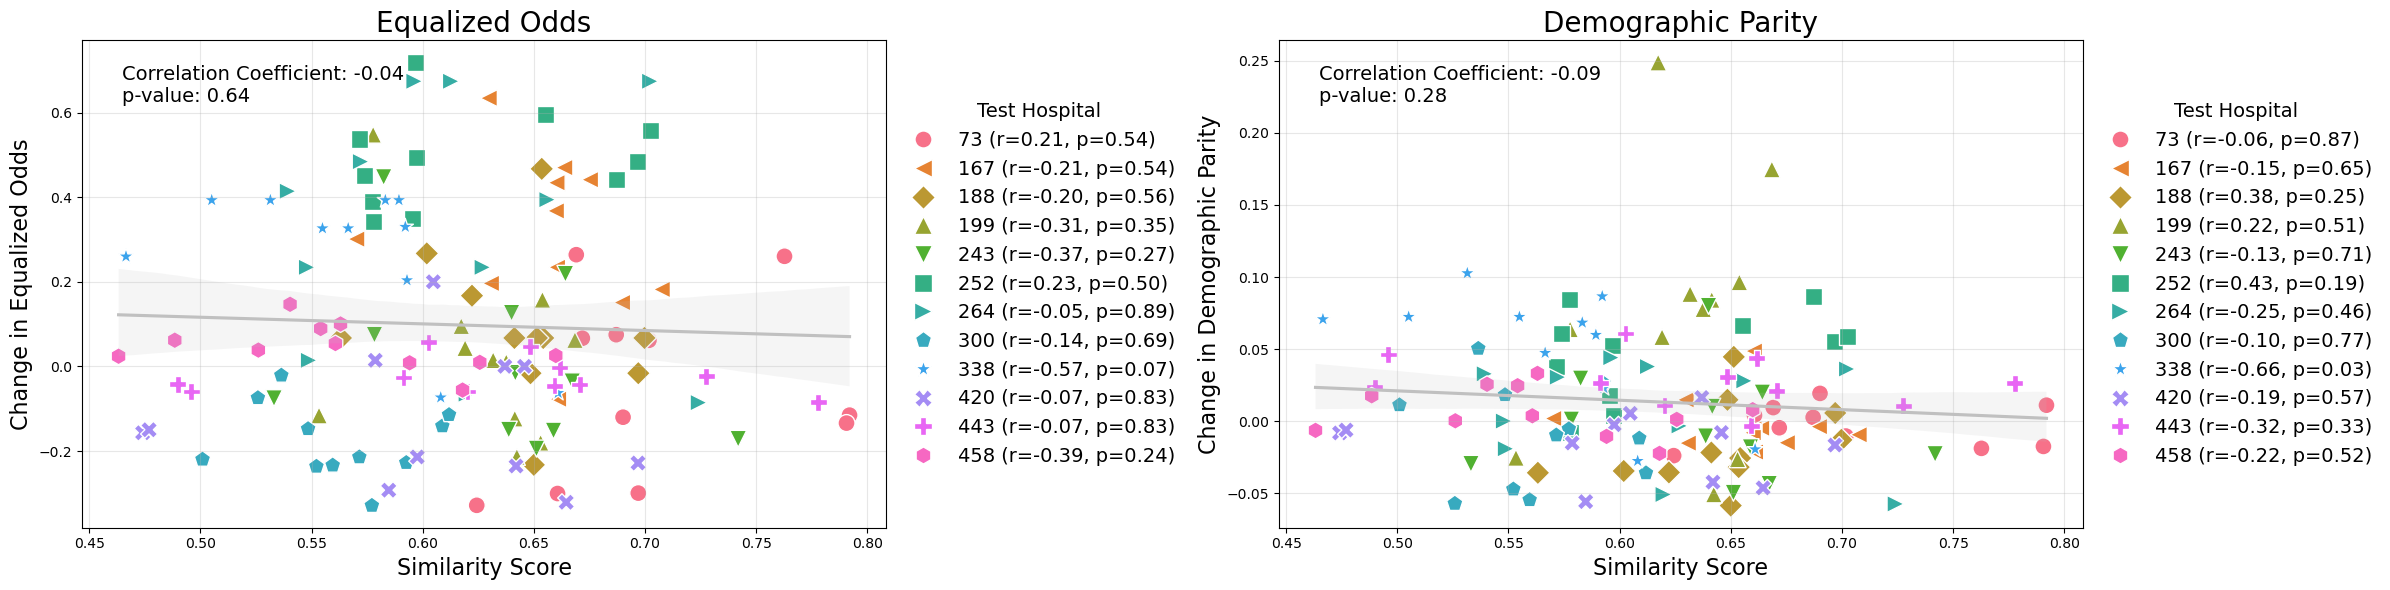

In [59]:
# VISUALIZATION: kl/score vs. change in EO/DP after addition (144 points, no subgroup differentiation)
score_mat = scores_xy

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

# Define the two different configurations
configs = [
    {'metric_diffs': add_eos_diffs, 'metric_name': 'Equalized Odds', 'ax': ax1},
    {'metric_diffs': add_dps_diffs, 'metric_name': 'Demographic Parity', 'ax': ax2}
]

for config in configs:
    metric_diffs = config['metric_diffs']
    metric_name = config['metric_name']
    ax = config['ax']
    
    # Prepare datapoints with test hospital information
    datapoints = []

    for j, test_hos in enumerate(hospital_ids):
        for k, train_hos in enumerate(hospital_ids):
            score = score_mat[j, k]
            metric_change = metric_diffs[test_hos][k]
            if not np.isnan(metric_change):
                datapoints.append({
                    'score': score,
                    'metric_change': metric_change,
                    'test_hospital': test_hos
                })

    # Convert to DataFrame for easier plotting
    plot_df = pd.DataFrame(datapoints)

    # Remove zeros if needed
    plot_df = plot_df[(plot_df['score'] != 0) & (plot_df['metric_change'] != 0)]

    # Define unique colors and markers for each test hospital
    unique_values = plot_df['test_hospital'].nunique()
    palette = sns.color_palette("husl", unique_values)
    markers = ['o', '<', 'D', '^', 'v', 's', '>', 'p', '*', 'X', 'P', 'h']

    # Calculate correlation for each test hospital
    correlation_dict = {}
    for test_hospital, group in plot_df.groupby('test_hospital'):
        if len(group) > 1:
            corr_coef, p_value = pearsonr(group['score'], group['metric_change'])
            correlation_dict[test_hospital] = (corr_coef, p_value)
        else:
            correlation_dict[test_hospital] = (np.nan, np.nan)

    # Scatterplot with hue and style for 'test_hospital'
    sns.scatterplot(data=plot_df, x='score', y='metric_change',
                    hue='test_hospital', style='test_hospital',
                    palette=palette, markers=markers, s=150, ax=ax)

    # Add regression line
    sns.regplot(x='score', y='metric_change', data=plot_df,
                scatter=False, color='silver', ax=ax)

    # Update legend labels with correlation coefficients
    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for label in labels:
        try:
            test_hospital = int(label)
            corr_coef, p_value = correlation_dict.get(test_hospital, (np.nan, np.nan))
            new_label = f'{label} (r={corr_coef:.2f}, p={p_value:.2f})'
        except ValueError:
            new_label = label
        new_labels.append(new_label)

    # Compute overall correlation coefficient and p-value
    corr_coef, p_value = pearsonr(plot_df['score'], plot_df['metric_change'])

    # Add correlation text on the plot
    text_str = f'Correlation Coefficient: {corr_coef:.2f}\np-value: {p_value:.2f}'
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes,
            fontsize=14, verticalalignment='top')

    # Customize legend
    ax.legend(handles=handles, labels=new_labels, loc='center left',
              bbox_to_anchor=(1, 0.5), frameon=False, fontsize=14).set_title('Test Hospital', prop={'size': 14})

    # Set axis labels
    ax.set_title(f'{metric_name}', fontsize=20)
    ax.set_xlabel('Similarity Score', fontsize=16)
    ax.set_ylabel(f'Change in {metric_name}', fontsize=16)
    
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Section 3: Ablations
